<a href="https://colab.research.google.com/github/Witcape/3D_Printing/blob/main/Final_Results%20/ALL_PARAMS_UNET_CLAHE_FINAL_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

In [2]:
pip install opencv-python

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage
from keras.models import Sequential
from keras.layers import Conv2D
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import numpy as np
import math
import os
%matplotlib inline

In [5]:
# define the SRCNN model
def model():

    # define model type
    SRCNN = Sequential()

    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))

    # define optimizer
    adam = Adam(learning_rate=0.0003)

    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])

    return SRCNN

In [6]:
def shave(image, border):
    img = image[border: -border, border: -border]
    return img
def predict_and_overwrite(image_path):
    # Load the SRCNN model with weights
    srcnn = model()
    srcnn.load_weights("3051crop_weight_200.h5")

    # Load the degraded image
    degraded = cv2.imread(image_path)

    # Convert the image to YCrCb - (SRCNN trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)

    # Create image slice and normalize
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255

    # Perform super-resolution with SRCNN
    pre = srcnn.predict(Y, batch_size=1)

    # Post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)

    # Pad the output Y channel to match the dimensions
    output_Y = np.pad(pre[0, :, :, 0], ((6, 6), (6, 6)), mode='constant')

    # Construct the super-resolved YCrCb image
    output = np.stack([output_Y, temp[:, :, 1], temp[:, :, 2]], axis=-1)

    # Convert the super-resolved image to BGR
    output = cv2.cvtColor(output, cv2.COLOR_YCrCb2BGR)

    # Shave the borders
    output = shave(output, 6)

    # Resize the image to 256x256
    output = cv2.resize(output, (256, 256))

    # Overwrite degraded image with super-resolved output
    cv2.imwrite(image_path, output)

In [7]:
def is_supported_format(filename):
    supported_formats = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    return filename.lower().endswith(supported_formats)

In [8]:
# for dirname, _, filenames in os.walk("/content/drive/MyDrive/Final_Final/Train"):
#     for filename in filenames:
#         if is_supported_format(filename):
#             img_path=os.path.join(dirname, filename)
#             predict_and_overwrite(img_path)

# for dirname, _, filenames in os.walk("/content/drive/MyDrive/Final_Final/Test"):
#     for filename in filenames:
#         if is_supported_format(filename):  # Check if the file is in a supported format
#             img_path=os.path.join(dirname, filename)
#             predict_and_overwrite(img_path)

In [9]:
# path='/content/model.h5'
# dataset=path.File(path,"r")
# import h5py

im_shape = (256,256)
TRAINING_DIR = "/content/drive/MyDrive/Final_Final/Train"
TEST_DIR = "/content/drive/MyDrive/Final_Final/Test"
seed = 10
BATCH_SIZE = 128

In [10]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        preprocessing_function=preprocess_input,
        #rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [11]:
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.0)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 701 images belonging to 3 classes.
Found 174 images belonging to 3 classes.
Found 387 images belonging to 3 classes.
Classes: ['Normal', 'Shaghetti', 'Stringing']


In [12]:
# # Assuming `train_generator` is your DirectoryIterator object
# for i in range(9):
#     plt.subplot(330 + 1 + i)
#     batch = next(train_generator)[0] * 255
#     image = batch[0].astype('uint8')
#     plt.imshow(image)

# plt.show()

UNet

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Dropout, concatenate, Input, Dense, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
import time

def unet(input_img):
    # Downsampling path
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    mp1 = MaxPool2D((2, 2))(c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(mp1)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    mp2 = MaxPool2D((2, 2))(c4)

    # Bottleneck
    dr1 = Dropout(0.3)(mp2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(dr1)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    # Upsampling path
    up1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    merge1 = concatenate([c4, up1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge1)

    up2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
    merge2 = concatenate([c2, up2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same')(merge2)

    return c8

# Model definition
input_img = Input(shape=(256, 256, 3))  # Reduced input size
x = GlobalAveragePooling2D()(unet(input_img))  # Replace Flatten with GAP
x = Dropout(0.3)(x)
x = Dense(64, activation=LeakyReLU(alpha=0.1))(x)  # Smaller dense layer
z = Dense(3, activation='softmax')(x)
model = Model(input_img, z)
model.summary()

# Compile and train
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
start_time = time.time()
plotter = model.fit(train_generator, validation_data=test_generator, epochs=10, batch_size=2)  # Smaller batch size
training_time = time.time() - start_time
print("Training Time: {:.2f} seconds".format(training_time))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

4/4 [==============================] - 23s 5s/step - loss: 1.0913 - accuracy: 0.3979
Test Accuracy: 0.40
4/4 [==============================] - 23s 5s/step
Accuracy: 0.40
Sensitivity (Recall): 0.40
Specificity: 0.40
F1 Score: 0.40
Precision: 0.41
MCC: 0.0826
Cohen's Kappa: 0.0814
AUC-ROC: 0.55
39.79%
39.79%
39.51%
41.02%
39.91%
0.0826
0.0814


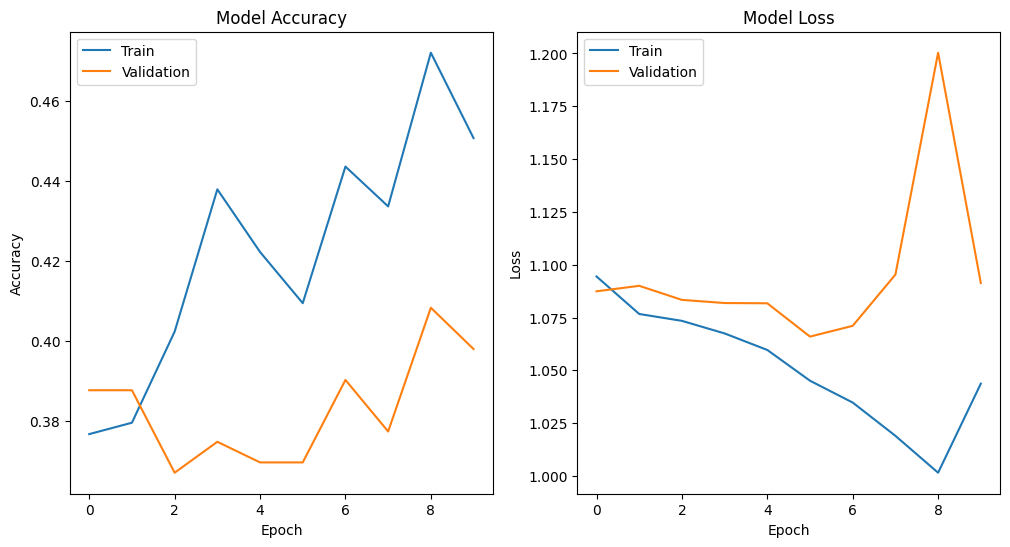

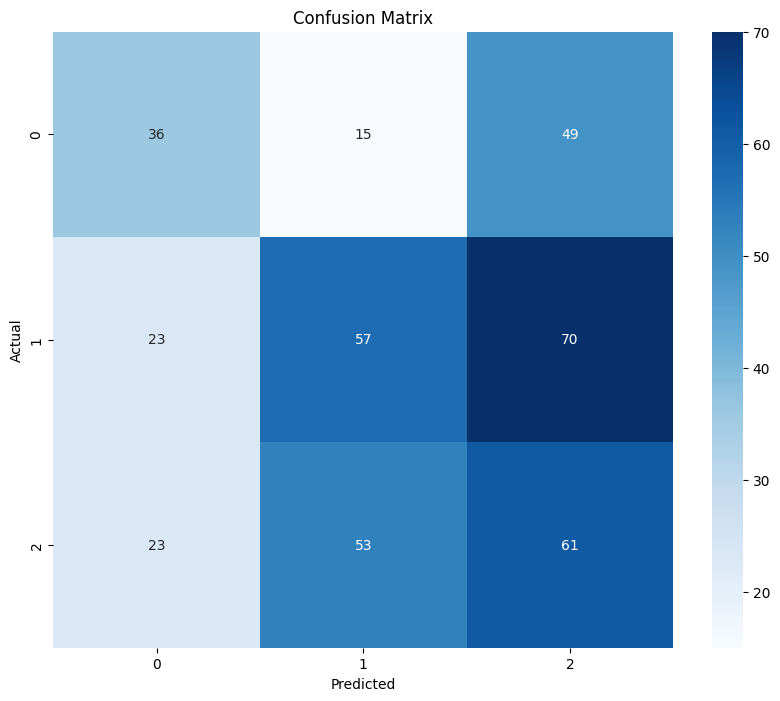

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef, cohen_kappa_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict the test data
test_preds = model.predict(test_generator)
test_pred_classes = np.argmax(test_preds, axis=1)
true_classes = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(true_classes, test_pred_classes)
precision = precision_score(true_classes, test_pred_classes, average='weighted')
sensitivity = recall_score(true_classes, test_pred_classes, average='weighted')  # Sensitivity = Recall
f1 = f1_score(true_classes, test_pred_classes, average='weighted')
conf_matrix = confusion_matrix(true_classes, test_pred_classes)
mcc = matthews_corrcoef(true_classes, test_pred_classes)
kappa = cohen_kappa_score(true_classes, test_pred_classes)

# Calculate specificity
specificity = np.mean([conf_matrix[i, i] / (np.sum(conf_matrix[i, :]) - conf_matrix[i, i] + conf_matrix[i, i]) for i in range(len(conf_matrix))])

print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"MCC: {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# AUC-ROC
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(true_classes, num_classes=3), test_preds, multi_class='ovr')
print(f"AUC-ROC: {roc_auc:.2f}")

# To copy easily
print(f"{accuracy * 100:.2f}%")
print(f"{sensitivity * 100:.2f}%")
print(f"{specificity * 100:.2f}%")
print(f"{precision * 100:.2f}%")
print(f"{f1 * 100:.2f}%")
print(f"{mcc:.4f}")
print(f"{kappa:.4f}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(plotter.history['accuracy'])
plt.plot(plotter.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(plotter.history['loss'])
plt.plot(plotter.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()